In [16]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import sys
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from config import *
from N_ranking_utils import *
from N_plotting_utils import *

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
def get_scores(algorithm_portfolio, do_discrete_ranking,model,train_benchmark,dimension,sample_count_dimension_factor,result_dir='results',include_sample_size_in_model_name=False):
    t=pd.read_csv(f'{data_dir}/{result_dir}/{sample_count_dimension_factor}d_samples/{dimension}d_generalization_discrete_ranking_{do_discrete_ranking}/{algorithm_portfolio}/all_scores_{model}_{train_benchmark}.csv',index_col=0)
    t=t.melt(id_vars=['fold','budget', 'train_name', 'test_name','model','algorithms','features'])
    
    if include_sample_size_in_model_name:
        t['model']=t['features'].apply(lambda x: f'{x} {sample_count_dimension_factor}d' if x!='dummy' else x)
    else: 
        t['model']=t['features']
    return t

In [19]:
def plot_generalization_rankings(algorithm_portfolio, dimension, do_discrete_ranking, model='no_chain', plot_ranks=True, benchmarks=None, sample_count_dimension_factor=50,result_dir='results'):
    metrics=['misranking_score','loss']
    scores=[]
    all_model_ranks=pd.DataFrame()
    if benchmarks is None:
        benchmarks=all_benchmarks
    for train_name in benchmarks:
        t=get_scores(algorithm_portfolio, do_discrete_ranking, model, train_name,dimension,sample_count_dimension_factor,result_dir)
        for budget in [10,30,50]:
            for score in metrics:
            
                for test_name in all_benchmarks:
                    if train_name!=test_name:
                        tt=t.query('budget==@budget and train_name==@train_name and test_name==@test_name and variable==@score')
                        tt_medians=tt.groupby(['model']).median().sort_values('value', ascending=False)
                        if plot_ranks:
                            model_ranks=list(zip(tt_medians.index, tt_medians.reset_index().index))
                        else:
                            model_ranks=list(zip(tt_medians.index, tt_medians['value']))
                        model_ranks={m[0]:m[1] for m in model_ranks}

                        model_ranks_df=pd.DataFrame(model_ranks, index=pd.MultiIndex.from_tuples([(budget,score,train_name, test_name)], names=['budget','score','train_name','test_name']))
                        #print(model_ranks_df)
                        all_model_ranks=pd.concat([all_model_ranks,model_ranks_df])
                        
    

    # Here we create a figure instance, and three subplots
    fig, axes = plt.subplots(3,len(metrics),  figsize = (len(metrics)*4,12)) # width x height
    
    # We use a for loop to fill in each subplot with a heatmap
    for budget_index, budget in enumerate([10,30,50]):
        for score_index, score in enumerate(all_model_ranks.reset_index()['score'].drop_duplicates().values):
            temp=all_model_ranks.query('budget==@budget and score==@score').reset_index()
            temp['train_name']=temp['train_name'].apply(benchmark_name_mapping)
            temp['test_name']=temp['test_name'].apply(benchmark_name_mapping)
            temp=temp.drop(columns=['budget','score']).set_index(['train_name','test_name'])

            temp=temp[['dummy','ela','transformer','merged']]
            temp.columns = [t.replace("ela", "ELA") for t in temp.columns]
            #temp.to_csv(f'{data_dir}/figures_results/tome_for_analysis/{algorithm_portfolio}_rank_{plot_ranks}_budget_{budget}_score_{score}.csv')
            sns.heatmap(temp, cmap='YlGnBu',annot=True, ax=axes[budget_index][score_index])
            axes[budget_index][score_index].set_title(f'Budget: {budget} \n Metric: {score}')
    plt.tight_layout()
    plt.savefig(f'{data_dir}/figures_results/{result_dir}_{sample_count_dimension_factor}d_samples_{dimension}d_{algorithm_portfolio}_{model}_plot_ranks_{plot_ranks}.pdf')
    return t
    

In [91]:
def plot_generalization_rankings_multiple_sample_sizes(algorithm_portfolio, dimension, do_discrete_ranking, model='no_chain', plot_ranks=True, benchmarks=None, sample_count_dimension_factors=50,result_dir='results',scale_ela=False):
    metrics=['misranking_score','loss']
    scores=[]
    all_results=pd.DataFrame()
    all_model_ranks=pd.DataFrame()
    if benchmarks is None:
        benchmarks=all_benchmarks
    for train_name in benchmarks:
        results_generalization=pd.concat([get_scores(algorithm_portfolio, do_discrete_ranking, model, train_name,dimension,sample_count_dimension_factor,result_dir + f'_scaling_{scale_ela}',True) for sample_count_dimension_factor in sample_count_dimension_factors])
        results_same=pd.concat([get_scores(algorithm_portfolio, do_discrete_ranking, model, train_name,dimension,sample_count_dimension_factor,f'results_same_benchmark_scaling_{scale_ela}',True) for sample_count_dimension_factor in sample_count_dimension_factors])
        results_generalization['model']=results_generalization['model'].apply(lambda x: x.lower())

        for budget in [10,30,50]:
            for score in metrics:

                for test_name in all_benchmarks:
                    t=results_generalization if train_name!=test_name else results_same
                    tt=t.query('budget==@budget and train_name==@train_name and test_name==@test_name and variable==@score')

                    #tt['model']=tt['model'].apply(lambda x: f'{x} {sample_count_dimension_factor}d' if x!='dummy' else x)
                    tt_medians=tt.groupby(['model']).median(numeric_only=True).sort_values('value', ascending=False)
                    if plot_ranks:
                        model_ranks=list(zip(tt_medians.index, tt_medians.reset_index().index))
                    else:
                        model_ranks=list(zip(tt_medians.index, tt_medians['value']))
                    model_ranks={m[0]:m[1] for m in model_ranks}

                    model_ranks_df=pd.DataFrame(model_ranks, index=pd.MultiIndex.from_tuples([(budget,score,train_name, test_name)], names=['budget','score','train_name','test_name']))
                    #print(model_ranks_df)
                    all_model_ranks=pd.concat([all_model_ranks,model_ranks_df])


    # Here we create a figure instance, and three subplots
    fig, axes = plt.subplots(3,len(metrics),  figsize = (len(metrics)*5,12), sharex=True) # width x height

    # We use a for loop to fill in each subplot with a heatmap
    for budget_index, budget in enumerate([10,30,50]):
        for score_index, score in enumerate(all_model_ranks.reset_index()['score'].drop_duplicates().values):
            temp=all_model_ranks.query('budget==@budget and score==@score').reset_index()
            temp['train_name']=temp['train_name'].apply(benchmark_name_mapping)
            temp['test_name']=temp['test_name'].apply(benchmark_name_mapping)
            temp=temp.drop(columns=['budget','score']).set_index(['train_name','test_name'])
            ordered_features=['dummy']+[f'{f} {s}d' for f in ['ela','transformer','merged'] for s in sample_count_dimension_factors]

            temp=temp[ordered_features]
            temp.columns = [t.replace("ela ", "ELA ") for t in temp.columns]

            temp.to_csv(f'{data_dir}/figures_results/for_analysis/{algorithm_portfolio}_dimension_{dimension}_rank_{plot_ranks}_budget_{budget}_score_{score}.csv')

            sns.heatmap(temp, cmap='YlGnBu',annot=True, ax=axes[budget_index][score_index])
            axes[budget_index][score_index].set_title(f'Budget: {budget} \n Metric: {score}')
            temp['budget']=budget
            temp['score']=score
            all_results=pd.concat([all_results,temp])
    plt.tight_layout()
    plt.savefig(f'{data_dir}/figures_results/{result_dir}_sample_sizes_{dimension}d_{algorithm_portfolio}_{model}_plot_ranks_{plot_ranks}_ela_scaling_{scale_ela}.pdf')
    print(all_results)
    for score_index, score in enumerate(all_model_ranks.reset_index()['score'].drop_duplicates().values):
        results_summary=[]
        for benchmark in ['BBOB','AFFINE','RANDOM','ZIGZAG']:
            temp=all_results.query('train_name!=test_name and score==@score and test_name==@benchmark').reset_index()
            print(temp)
            ordered_indices=[]
            for c1,c2 in [('ELA 50d','ELA 100d'),   ('transformer 50d','transformer 100d'),   ('merged 50d','merged 100d'), ('ELA 50d','transformer 50d'), ('ELA 100d','transformer 100d'), ('merged 50d','ELA 50d'), ('merged 100d','ELA 100d')]:
                c1_rounded=temp[c1].apply(lambda x: round(x,2))
                c2_rounded=temp[c2].apply(lambda x: round(x,2))
                results_summary+=[( benchmark, f'{c1} > {c2} (count)', temp[temp[c1]>temp[c2]].shape[0]), ( benchmark, f'{c1} - {c2} (mean)', (temp[c1]-temp[c2]).mean())] 
                ordered_indices+=[f'{c1} > {c2} (count)', f'{c1} - {c2} (mean)',]
        t=pd.DataFrame(results_summary, columns=['test benchmark','hypothesis','value'])
        plt.figure(figsize=(7,5))
        sns.heatmap(t.pivot(index='test benchmark',columns='hypothesis').droplevel(0,axis=1).T.loc[ordered_indices], annot=True, cmap="YlGnBu")
        plt.tight_layout()
        plt.savefig(f'{data_dir}/figures_results/{result_dir}_sample_sizes_{dimension}d_{algorithm_portfolio}_{model}_hypothesis_{score}_ela_scaling_{scale_ela}.pdf')

    return all_results

In [ ]:
all_results=plot_generalization_rankings_multiple_sample_sizes("DE-GA-ES-PSO", 10,False, model='rf', plot_ranks=False,sample_count_dimension_factors=[50,100],result_dir='results_ela',scale_ela=True)

In [14]:
def plot_generalization_rankings_multiple_sample_sizes_new(algorithm_portfolio, dimension, do_discrete_ranking, model='no_chain', plot_ranks=True, benchmarks=None, sample_count_dimension_factors=50,result_dir='results'):
    metrics=['misranking_score','loss']
    scores=[]
    all_results=pd.DataFrame()
    all_model_ranks=pd.DataFrame()
    if benchmarks is None:
        benchmarks=all_benchmarks
    for train_name in benchmarks:
        results_generalization=pd.concat([get_scores(algorithm_portfolio, do_discrete_ranking, model, train_name,dimension,sample_count_dimension_factor,result_dir,True) for sample_count_dimension_factor in sample_count_dimension_factors])
        results_same=pd.concat([get_scores(algorithm_portfolio, do_discrete_ranking, model, train_name,dimension,sample_count_dimension_factor,'results_same_benchmark',True) for sample_count_dimension_factor in sample_count_dimension_factors])

        for budget in [10,30,50]:
            for score in metrics:

                for test_name in all_benchmarks:
                    t=results_generalization if train_name!=test_name else results_same
                    tt=t.query('budget==@budget and train_name==@train_name and test_name==@test_name and variable==@score')
                    #tt['model']=tt['model'].apply(lambda x: f'{x} {sample_count_dimension_factor}d' if x!='dummy' else x)
                    tt_medians=tt.groupby(['model']).median(numeric_only=True).sort_values('value', ascending=False)
                    if plot_ranks:
                        model_ranks=list(zip(tt_medians.index, tt_medians.reset_index().index))
                    else:
                        model_ranks=list(zip(tt_medians.index, tt_medians['value']))
                    model_ranks={m[0]:m[1] for m in model_ranks}

                    model_ranks_df=pd.DataFrame(model_ranks, index=pd.MultiIndex.from_tuples([(budget,score,train_name, test_name)], names=['budget','score','train_name','test_name']))
                    #print(model_ranks_df)
                    all_model_ranks=pd.concat([all_model_ranks,model_ranks_df])

    

    # Here we create a figure instance, and three subplots
    fig, axes = plt.subplots(3,len(metrics),  figsize = (len(metrics)*8,12), sharex=True) # width x height

    # We use a for loop to fill in each subplot with a heatmap
    for budget_index, budget in enumerate([10,30,50]):
        for score_index, score in enumerate(all_model_ranks.reset_index()['score'].drop_duplicates().values):
            temp=all_model_ranks.query('budget==@budget and score==@score').reset_index()
            temp['train_name']=temp['train_name'].apply(benchmark_name_mapping)
            temp['test_name']=temp['test_name'].apply(benchmark_name_mapping)
            temp=temp.drop(columns=['budget','score']).set_index(['train_name','test_name'])
            '''ordered_features=['dummy']+[f'{f} {s}d' for f in ['ela','transformer','merged'] for s in sample_count_dimension_factors]

            temp=temp[ordered_features]
            temp.columns = [t.replace("ela ", "ELA ") for t in temp.columns]
            temp.to_csv(f'{data_dir}/figures_results/for_analysis/{algorithm_portfolio}_dimension_{dimension}_rank_{plot_ranks}_budget_{budget}_score_{score}.csv')
'''
            sns.heatmap(temp, cmap='YlGnBu',annot=True, ax=axes[budget_index][score_index])
            axes[budget_index][score_index].set_title(f'Budget: {budget} \n Metric: {score}')
            temp['budget']=budget
            temp['score']=score
            all_results=pd.concat([all_results,temp])
    plt.tight_layout()
    #plt.savefig(f'{data_dir}/figures_results/{result_dir}_sample_sizes_{dimension}d_{algorithm_portfolio}_{model}_plot_ranks_{plot_ranks}.pdf')
    
    
    
    
    '''for score_index, score in enumerate(all_model_ranks.reset_index()['score'].drop_duplicates().values):
        results_summary=[]
        for benchmark in ['BBOB','AFFINE','RANDOM','ZIGZAG']:
            temp=all_results.query('train_name!=test_name and score==@score and test_name==@benchmark').reset_index()
            ordered_indices=[]
            for c1,c2 in [('ELA 50d','ELA 100d'),   ('transformer 50d','transformer 100d'),   ('merged 50d','merged 100d'), ('ELA 50d','transformer 50d'), ('ELA 100d','transformer 100d'), ('merged 50d','ELA 50d'), ('merged 100d','ELA 100d')]:
                c1_rounded=temp[c1].apply(lambda x: round(x,2))
                c2_rounded=temp[c2].apply(lambda x: round(x,2))
                results_summary+=[( benchmark, f'{c1} > {c2} (count)', temp[temp[c1]>temp[c2]].shape[0]), ( benchmark, f'{c1} - {c2} (mean)', (temp[c1]-temp[c2]).mean())] 
                ordered_indices+=[f'{c1} > {c2} (count)', f'{c1} - {c2} (mean)',]

        t=pd.DataFrame(results_summary, columns=['test benchmark','hypothesis','value'])
        plt.figure(figsize=(7,5))
        sns.heatmap(t.pivot('test benchmark','hypothesis').droplevel(0,axis=1).T.loc[ordered_indices], annot=True, cmap="YlGnBu")
        plt.tight_layout()
        #plt.savefig(f'{data_dir}/figures_results/{result_dir}_sample_sizes_{dimension}d_{algorithm_portfolio}_{model}_hypothesis_{score}.pdf')
'''
    return all_results

In [15]:
all_results=plot_generalization_rankings_multiple_sample_sizes_new("DE-GA-ES-PSO", 3,False, model='rf', plot_ranks=False,sample_count_dimension_factors=[100],result_dir='results_ela_scaling')

FileNotFoundError: [Errno 2] No such file or directory: 'new_data/results_ela_scaling/100d_samples/3d_generalization_discrete_ranking_False/DE-GA-ES-PSO/all_scores_rf_affine.csv'

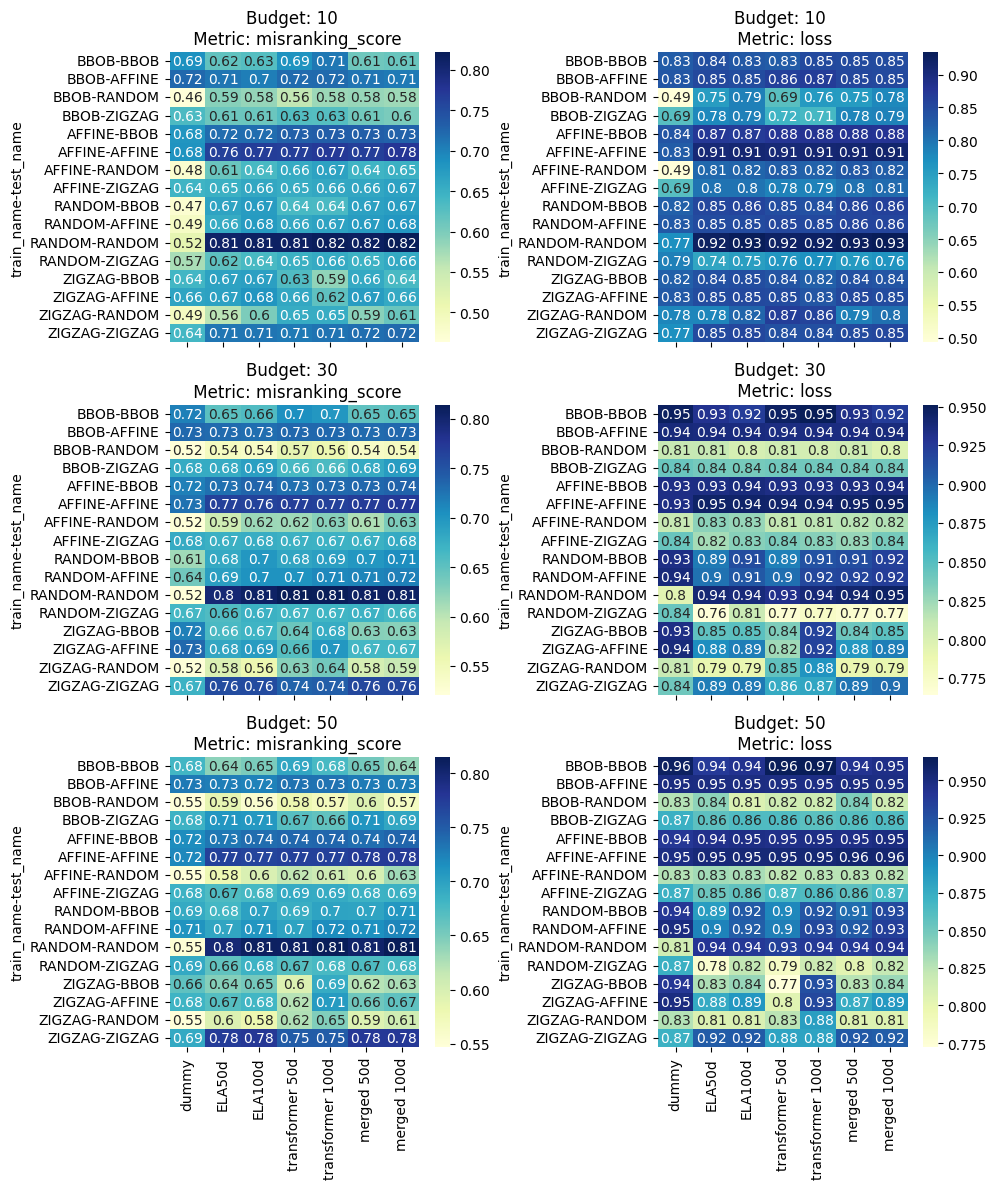

In [37]:
all_results=plot_generalization_rankings_multiple_sample_sizes("PSO1-PSO2-PSO3-PSO4-PSO8-PSO10", 10,False, model='rf', plot_ranks=False,sample_count_dimension_factors=[50,100],result_dir='results_ela')

-0.00231876265621489
0.017490967806524038
0.010752393366145085
-0.007457324107842278
-0.0006717957101403105
-0.003502951260548004
0.02047296986105085
BBOB


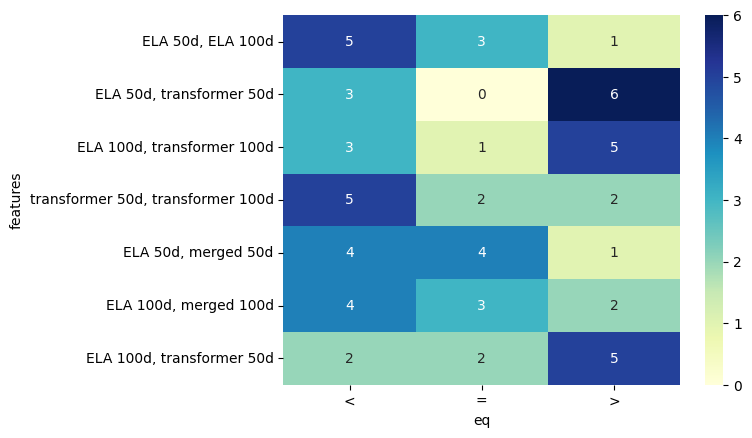

0.0034877159137184366
-0.00631483182758108
-0.019841910487219394
-0.0031494457158991462
-0.009230254284580797
-0.021119461642368664
-0.007753676523998498
AFFINE


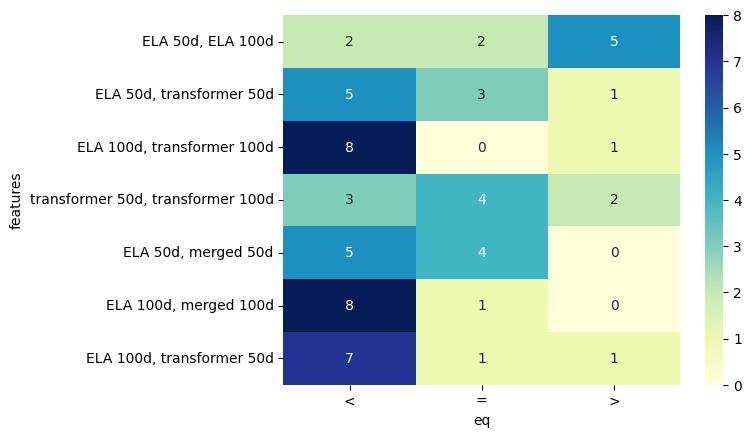

-0.04407521364715672
0.05419336504146477
0.10385154180876077
-0.0063377676065004
0.006757279986417286
0.0011403148104591754
0.09826857868862149
RANDOM


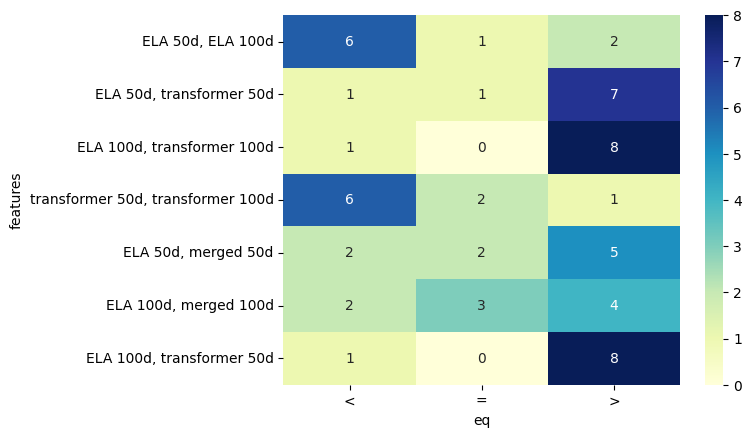

-0.005478234789796865
0.06631255008564696
0.03178703941298011
-0.018158104162037003
0.007414512098248838
0.019602861937674465
0.07231266351660659
ZIGZAG


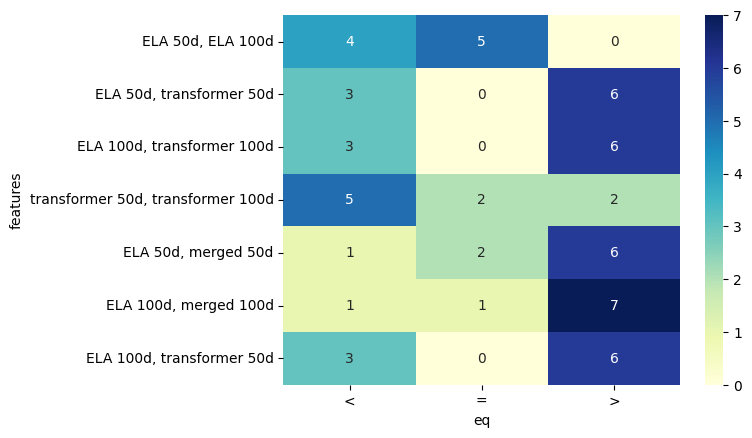

In [69]:

for train_name in ['BBOB','AFFINE','RANDOM','ZIGZAG']:
    temp=all_results.query('train_name!=test_name and score=="loss" and train_name==@train_name').reset_index()
    results_summary=[]
    ordered_indices=[]
    for c1,c2 in [('ELA 50d','ELA 100d'), ('ELA 50d','transformer 50d'), ('ELA 100d','transformer 100d'),  ('transformer 50d','transformer 100d'), ('ELA 50d','merged 50d'), ('ELA 100d','merged 100d'),('ELA 100d','transformer 50d')]:
        c1_rounded=temp[c1].apply(lambda x: round(x,2))
        c2_rounded=temp[c2].apply(lambda x: round(x,2))

        '''print(f'{c1} > {c2}')
        print(temp[c1_rounded>c2_rounded].shape)
        print(f'{c1} < {c2}')
        print(temp[c1_rounded<c2_rounded].shape)
        print(f'{c1} = {c2}')
        print(temp[c1_rounded==c2_rounded].shape)'''
        results_summary+=[(f'{c1}, {c2}','>', temp[c1_rounded>c2_rounded].shape[0]),  (f'{c1}, {c2}','<', temp[c1_rounded<c2_rounded].shape[0]),  (f'{c1}, {c2}','=', temp[c1_rounded==c2_rounded].shape[0])] 
        ordered_indices+=[f'{c1}, {c2}']
        #print(abs((temp[c1]-temp[c2])).mean())
        print((temp[c1]-temp[c2]).median())

    print(train_name)
    t=pd.DataFrame(results_summary, columns=['features','eq','value'])
    plt.figure()
    sns.heatmap(t.pivot('features','eq').droplevel(0,axis=1).loc[ordered_indices], annot=True, cmap="YlGnBu")
    plt.show()

In [ ]:
for dimension in [3,10]:
    for sample_count_dimension_factor in [50,100]:
        for algorithm_portfolio in ['DE-GA-ES-PSO']:
            for plot_ranks in [False]:
                plot_generalization_rankings(algorithm_portfolio, dimension,False, model='rf', plot_ranks=plot_ranks,sample_count_dimension_factor=sample_count_dimension_factor,result_dir='results_ela')

In [95]:
def get_predictions(algorithm_portfolio, do_discrete_ranking,model,train_benchmark,test_benchmark, dimension,sample_count_dimension_factor,budget,fold,result_dir):
    all_predictions=[]
    for features in ['dummy','ela','transformer','merged']:
        t=pd.read_csv(f'{data_dir}/{result_dir}/{sample_count_dimension_factor}d_samples/{dimension}d_generalization_discrete_ranking_{do_discrete_ranking}/{algorithm_portfolio}/model_{model}_budget_{budget}_fold_{fold}_train_{train_benchmark}_{features}_{test_benchmark}_pred.csv',index_col=0)

        t['features']=features
        all_predictions+=[t]
        
    t=pd.read_csv(f'{data_dir}/{result_dir}/{sample_count_dimension_factor}d_samples/{dimension}d_generalization_discrete_ranking_{do_discrete_ranking}/{algorithm_portfolio}/model_{model}_budget_{budget}_fold_{fold}_train_{train_benchmark}_dummy_{test_benchmark}_test.csv',index_col=0)
    t['features']='true'
    all_predictions+=[t] 
    all_predictions=pd.concat(all_predictions)
    return all_predictions

In [ ]:
dimension=10
sample_count_dimension_factors=[50,100]
algorithm_portfolio="DE-GA-ES-PSO"
instance_id=1
model='rf'
all_budgets=[10,30,50]
for train_benchmark in ['random','m4','affine']:

    plt.figure(figsize=(12,2))
    fig, axes = plt.subplots(3, 1, figsize = (12,8), sharex=True) 

    for budget_index, budget in enumerate([10,30,50]):
        features_sorted=[]
        all_results=[]
        for features in ['dummy','ela','transformer','merged']:
            for sample_count_dimension_factor in sample_count_dimension_factors:

                predictions = pd.concat([get_predictions(algorithm_portfolio, False,model,train_benchmark,'bbob',dimension,sample_count_dimension_factor,budget,fold,'results_ela_scaling_True') for fold in range(0,10)])

                predictions = predictions.reset_index().groupby(['features','f']).mean().reset_index().set_index('f')
                for f in [f'{i}_{instance_id}' for i in range(1,25)]:

                    #print(features)
                    f_true=predictions.loc[f].query('features=="true"').drop(columns=['features'])
                    f_pred=predictions.loc[f].query('features==@features').drop(columns=['features'])
                    score=calculate_loss(f_true,f_pred)
                    all_results+=[(f,f'Features: {features if features!="ela" else "ELA"}, Sample size: {sample_count_dimension_factor}d',score)]
                features_sorted+=[f'Features: {features if features!="ela" else "ELA"}, Sample size: {sample_count_dimension_factor}d']
            #plt.show()
        d=pd.DataFrame(all_results,columns=['f','features','score'])

        t=d.pivot('features','f').droplevel(level=0,axis=1).loc[features_sorted]
        axes[budget_index].set_title(f'Budget: {budget}')
        sns.heatmap(t[[f'{i}_{instance_id}' for i in range(1,25)]],annot=True,fmt='.1f',cmap='YlGnBu',vmin=0,vmax= 1, ax=axes[budget_index])
        axes[budget_index].set(ylabel=None)
        if budget_index==len(all_budgets)-1:
            axes[budget_index].set_xticklabels(axes[budget_index].get_xticklabels(), rotation=90)
        else:
            axes[budget_index].set_xticklabels([])
            x_axis = axes[budget_index].axes.get_xaxis()
            x_axis.set_visible(False)
    plt.tight_layout()
    plt.margins(x=0)
    plt.savefig(f'{data_dir}/figures_results/errors_{"-".join([str(s) for s in sample_count_dimension_factors])}d_samples_{dimension}d_generalization_{algorithm_portfolio}_{model}_train_{train_benchmark}_test_bbob.pdf',bbox_inches='tight')
    plt.show()